# ISO Playlists EDA
- Preprocessing
- Exploratory Data Analysis
- Conclusions and Evaluation

In [12]:
import requests
import threading
from requests_oauthlib import OAuth1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import random

In [13]:
API_TOKEN = open('api').readline()
SOAR_ID = "etoj1vywg8pvjmuxgovg6l9kb"
headers = {"Authorization": f"Bearer {API_TOKEN}"}

Get all of the playlists in the user's profile.

In [14]:
url = f"https://api.spotify.com/v1/users/{SOAR_ID}/playlists"
playlists = requests.get(url, headers=headers, params={'limit': 50}).json()
playlist_ids = [v['id'] for v in playlists['items']]
playlist_descriptions = [v['name'] + ' - ' + v['description'] for v in playlists['items']]

In [15]:
playlist_descriptions

['iso30 - nervous, agitated, energetic to calm, relaxed, soothed',
 'iso29 - tender to powerful',
 'iso28 - happy to powerful',
 'iso27 - happy to tender',
 'iso26 - sad to powerful',
 'iso25 - sad to tender',
 'iso24 - sad to happy',
 'iso23 - tense to powerful',
 'iso22 - tense to tender',
 'iso21 - tense to happy',
 'iso20 - anxious to meditative to relaxed',
 'iso19 - melancholic to tender to affectionate',
 'iso18 - irritated to meditative to soothed',
 'iso17 - serene to animated to energetic',
 'iso16 - sad to animated to joyful',
 'iso15 - tenderness to joyful to energetic',
 'iso14 - energetic to dreamy to relaxed',
 'iso13 - nervous to animated to energetic',
 'iso12 - angry to amused to soothed',
 'iso11 - sad to soothed to triumphant',
 'iso10 - anxious to relaxed to joyful',
 'iso09 - sad to happy',
 'iso08 - nervous to calm',
 'iso07 - sluggish to energized',
 'iso06 - Sad to Hopeful',
 'iso05 - lonely to connected',
 'iso04 - calm, dreamy, melancholic to calm, relaxed, m

After we get all of the playlist IDs, we now need to get the track ID of all of the tracks in each playlist. (*TODO: with more data it would probably be a good idea to multithread the requests*)

In [16]:
labeled_data = {}

def get_playlist_info(playlist_id, playlist_description,
                      headers, lock):
    url = f"https://api.spotify.com/v1/playlists/{playlist_id}/tracks"
    tracks = requests.get(url, headers=headers)
    tracks = tracks.json()
    track_ids = [p['track']['id'] for p in tracks['items']]
    lock.acquire()
    labeled_data[playlist_description] = track_ids
    lock.release()

# Create threads
threads = []
lock = threading.Lock()
for pid, pdescript in zip(playlist_ids, playlist_descriptions):
    threads.append(threading.Thread(target=get_playlist_info,
                                    args=(pid, pdescript, headers, lock)))
# Start threads
for thread in threads:
    thread.start()

# Join threads
for thread in threads:
    thread.join()

In [17]:
json.dump(labeled_data, open("data/playlist-tracks-id", "w+"))

Now we get all of the audio features associated with each track in a playlist.

In [18]:
features = {}

def get_audio_features(playlist, track_ids, headers, lock):
    audio_feature_request = {'ids':','.join(track_ids)}
    audio_url = "https://api.spotify.com/v1/audio-features"
    aud_features = requests.get(audio_url, headers=headers, 
                 params=audio_feature_request)
    aud_features = aud_features.json()['audio_features']
    lock.acquire()
    features[playlist] = aud_features
    lock.release()

# Create threads
threads = []
lock = threading.Lock()
for k, v in labeled_data.items():
    threads.append(threading.Thread(target=get_audio_features,
                                    args=(k, v, headers, lock)))
# Start threads
for thread in threads:
    thread.start()

# Join threads
for thread in threads:
    thread.join()

In [19]:
json.dump(features, open("data/playlist-tracks-features", "w+"))

In [20]:
features.keys()

dict_keys(['iso25 - sad to tender', 'iso29 - tender to powerful', 'iso26 - sad to powerful', 'iso24 - sad to happy', 'iso27 - happy to tender', 'iso13 - nervous to animated to energetic', 'iso21 - tense to happy', 'iso22 - tense to tender', 'iso09 - sad to happy', 'iso10 - anxious to relaxed to joyful', 'iso17 - serene to animated to energetic', 'iso12 - angry to amused to soothed', 'iso11 - sad to soothed to triumphant', 'iso20 - anxious to meditative to relaxed', 'iso19 - melancholic to tender to affectionate', 'iso08 - nervous to calm', 'iso04 - calm, dreamy, melancholic to calm, relaxed, meditative', 'iso14 - energetic to dreamy to relaxed', 'iso18 - irritated to meditative to soothed', 'iso30 - nervous, agitated, energetic to calm, relaxed, soothed', 'iso06 - Sad to Hopeful', 'iso05 - lonely to connected', 'iso15 - tenderness to joyful to energetic', 'iso23 - tense to powerful', 'iso03 - anxious to calm, motivated', 'iso16 - sad to animated to joyful', 'iso28 - happy to powerful',

In [21]:
features['iso09 - sad to happy'][0].keys()

dict_keys(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms', 'time_signature'])

We now plot the individual metrics as a function of the song time step.

In [43]:
def plot_attribute(attribute, features):
    plt.figure(figsize=(40, 20), constrained_layout=True)
    fig, ax = plt.subplots(6, 3)
    fig.suptitle(f"{attribute} vs. time step of a given playlist")
    fig.set_size_inches(18.5, 10.5)
    nonempty_keys = [v for v in features.keys() if features[v] != [None]]
    # plot valence
    ax_num = 1
    for i in range(6):
        for j in range(3):
            axis = ax[i][j]
            feature = features[nonempty_keys[i]]
            featvs_time = [v[attribute] for v in feature]
            axis.plot(featvs_time)
            axis.set_title(list(features.keys())[i], fontsize=10)
            axis.axes.get_xaxis().set_visible(False)
    plt.show()

<Figure size 2880x1440 with 0 Axes>

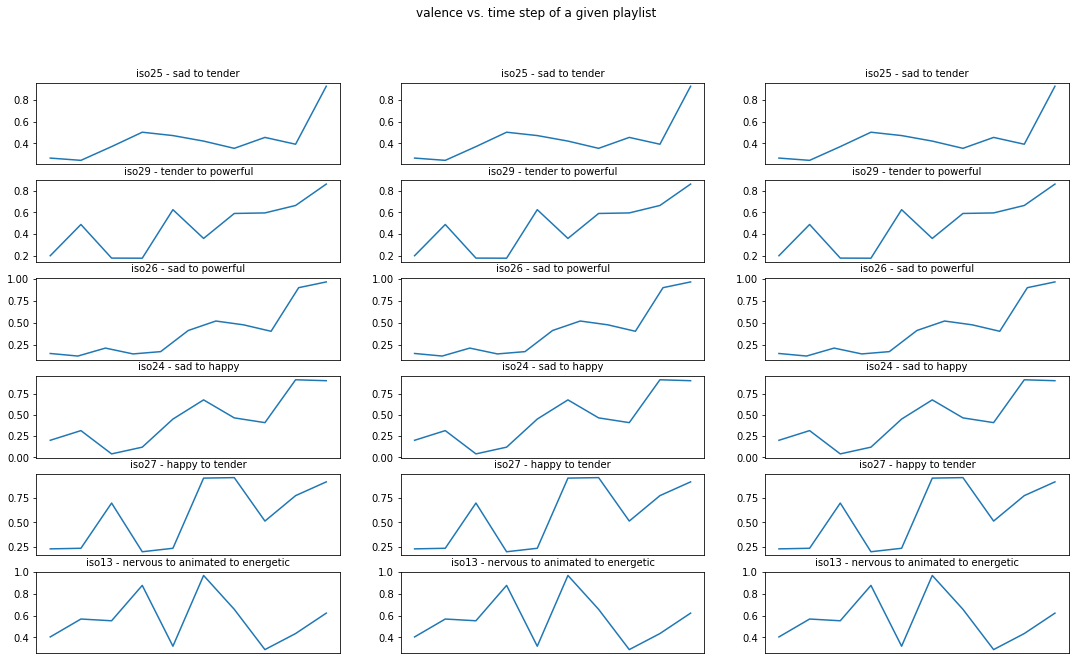

In [47]:
plot_attribute('valence', features)

## Conclusion and Evaluation
From our generated graphs we see apparent correlations between the various features: valence, danceability, energy, and the moods that the playlists supposedly emmulate. Moving forward, this demonstrates that we may be able to create synthetic data through simple linear regression techniques. Generally, we see that many of the curves present look logarithmic. Thus, may be represented using the general form: 
$$a\cdot \frac{\log{x}}{\log b} + c, \qquad a, b, c \in \mathbb{R}.$$

One limitation to such a regression is that it is also not a function of specified input length.

Further EDA needs to be done on keyword clustering – currently, the various graphs for each projected curve is jagged, graphs and their respective data points can be averaged together based on the various starting keywords and ending keywords.

# Spotify Playlist Query Based on Audio Features
In this section, we examine the efficacy of spotify queries based on Spotify extracted audio features. We start by going through each playlist querying the target feature based on the exact extracted audio feature. Then, we increase the testing range by using the min, max feature queries. The efficacy of each test is measured by whether or not the target track appears in the top 1, 5, 10, 20 returned results.

The Spotify `recommendations` API endpoint has 3 required fields: `seed_artists`, `seed_genres`, `seed_tracks`. My understanding of these seeds are that they provide a reference point for Spotify to begin searching the space of possible song which match the other `recommendation` criterions.

In [113]:
# we start by getting the *fixed* genre recommendations from spotify
# we probably want the user to choose this at the initialiation of the app.
url = "https://api.spotify.com/v1/recommendations/available-genre-seeds"
genres = requests.get(url, headers=headers).json()['genres']

# we choose 3 random genres
genres = 'acoustic'
          

In [114]:
url = 'https://api.spotify.com/v1/recommendations'

In [115]:
ld = [v for v in labeled_data if len(labeled_data[v]) != 0]

## Exact Feature Query ($\pm$0%)

In [121]:
# choose a playlist with non-zero features
ld = [v for v in labeled_data if len(labeled_data[v]) != 0]
ld.remove('iso02 - Heiderscheit 2015; doi: {10.1093&#x2F;mtp&#x2F;miu042}')
ld.remove('iso01 - Heiderscheit 2015; doi: {10.1093&#x2F;mtp&#x2F;miu042}')
ref = ld
for iso in ld:
    ref.remove(iso)
    # get track for search
    i = random.randint(0, 9)
    trackid = labeled_data[iso][i]
    feature = features[iso][i]
    feature.pop('id', None); feature.pop('type', None); feature.pop('uri', None)
    feature.pop('track_href', None); feature.pop('analysis_url', None)
    feature.pop('duration_ms', None)
    # these three playlists
    playlists = [random.randint(0, len(ld) - 1) for i in range(2)]

    # get seed tracks
    r_tracks = [labeled_data[ld[playlists[i]]][random.randint(0, 9)] 
                for i in range(2)]
    
    # get artists from seed tracks and query
    urls = [f'https://api.spotify.com/v1/tracks/{id}'
            for id in r_tracks]
    req = [requests.get(url, headers=headers).json() for url in urls]
    artists = [r['album']['artists'][0]['id'] for r in req]
    ref.append(iso)
    
    # make requests
    params = {f'target_{k}': v for k, v in feature.items()}
    params['seed_artists'] = ','.join(artists)
    params['seed_tracks'] = ','.join(r_tracks)
    params['seed_genres'] = genres
    req = requests.get(url, headers=headers, params=params).json()
    break

In [122]:
print(trackid)

0QZ5yyl6B6utIWkxeBDxQN


In [128]:
req['tracks'][0]['id']

'2IAR0DziHCjSu16gR4ihvy'

In [80]:
feature.pop('id')

'6zvqq50PL7io0rprbkrYc9'

In [82]:
feature.pop('key'); feature.pop('loudness')

-8.024

In [83]:
feature

{'danceability': 0.668,
 'energy': 0.547,
 'mode': 1,
 'speechiness': 0.0353,
 'acousticness': 0.398,
 'instrumentalness': 0.0766,
 'liveness': 0.0931,
 'valence': 0.192,
 'tempo': 83.5,
 'type': 'audio_features',
 'uri': 'spotify:track:6zvqq50PL7io0rprbkrYc9',
 'track_href': 'https://api.spotify.com/v1/tracks/6zvqq50PL7io0rprbkrYc9',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/6zvqq50PL7io0rprbkrYc9',
 'duration_ms': 194871,
 'time_signature': 4}

In [65]:
req[0]['album']['artists']

[{'external_urls': {'spotify': 'https://open.spotify.com/artist/6USv9qhCn6zfxlBQIYJ9qs'},
  'href': 'https://api.spotify.com/v1/artists/6USv9qhCn6zfxlBQIYJ9qs',
  'id': '6USv9qhCn6zfxlBQIYJ9qs',
  'name': 'Dominic Fike',
  'type': 'artist',
  'uri': 'spotify:artist:6USv9qhCn6zfxlBQIYJ9qs'}]

In [33]:
random.randint(0, 1)

1

## Approximate Feature Query ($\pm$3%)

## Approximate Feature Query ($\pm$5%)

## Approximate Feature Query ($\pm$7%)

## Approximate Feature Query ($\pm$10%)

## Approximate Feature Query ($\pm$12%)

## Approximate Feature Query ($\pm$15%)

## Approximate Feature Query ($\pm$20%)